# Demo 01: Echogram fu
### `themachinethatgoesping` tutorial series

Here we show how to create echograms from acoustic data and how to do magic with them

In [1]:
%matplotlib widget

import numpy as np
import themachinethatgoesping as theping
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [2]:
# data folder
folder = '/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/PLUME_0/'

# find all Kongsberg files in the list of folders
files = sorted(theping.echosounders.index_functions.find_files(folder,['.raw']))
cache_files = theping.echosounders.index_functions.get_index_paths(files)

# create the file handler
fileHandler = theping.echosounders.simradraw.SimradRawFileHandler(files, cache_files)


Found 50 files
indexing files ⠄ 99% :00s<00m:00s] [Found: 1881429 datagrams in 50 files (23769MB)]                                                
Initializing ping interface ⠠ 99% :11s<00m:00s] [Done]                                              


# Prepare pings for echogram processing

In [3]:
# get pings that contain WCD
pings = theping.pingprocessing.filter_pings.by_features(fileHandler.get_pings(),['watercolumn.amplitudes'])

# split pings by channle
pings_by_channel = theping.pingprocessing.split_pings.by_channel_id(pings)

In [4]:
#sort channels by frequency (the number after 'ES')
pings_by_channel = dict(reversed(sorted(pings_by_channel.items(), key=lambda item: int(item[0].split('ES')[1].split('-')[0].split('_')[0]))))

for k,p in pings_by_channel.items():
    print(k,len(p))

WBT 400058-15 ES333-7C_ES 106599
WBT 400052-15 ES200-7C_ES 106599
WBT 400051-15 ES120-7C_ES 106599
WBT 400050-15 ES70-7C_ES 106599
WBT 400040-15 ES38-7_ES 106599
WBT 400038-15 ES18_ES 106599


# create echograms from the data

In [5]:
echogram_data = {}

for k,pings in tqdm(pings_by_channel.items()):
    echogram_data[k] = theping.pingprocessing.watercolumn.echograms.EchogramBuilder.from_pings(
        pings,
        pss=theping.echosounders.pingtools.PingSampleSelector(),
        wci_value = 'sv/av/pv/rv',
        linear_mean=True,
        no_navigation=False,
        apply_pss_to_bottom=False,
        force_angle=None,
        depth_stack=False,
        verbose=False)

  0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
# set axis
for k,e in tqdm(echogram_data.items()):
    e.set_x_axis_date_time()
    e.set_y_axis_depth()

  0%|          | 0/6 [00:00<?, ?it/s]

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime
import os

def find_closest_index(sorted_array, target):
    """
    Find the index of the closest number in a sorted array using NumPy.

    Parameters:
        sorted_array (np.ndarray): A sorted NumPy array of numbers.
        target (float): The target number to find the closest to.

    Returns:
        int: The index of the closest number in the sorted array.
    """
    # Use searchsorted to find the insertion point
    idx = np.searchsorted(sorted_array, target, side="left")

    # Check the boundary conditions
    if idx == 0:
        return 0
    if idx == len(sorted_array):
        return len(sorted_array) - 1

    # Check the closest of the two neighbors
    prev_idx = idx - 1
    if abs(sorted_array[idx] - target) < abs(sorted_array[prev_idx] - target):
        return idx
    else:
        return prev_idx
        
class InteractiveLineBuilder:
    def __init__(self, echoviewer, filepath = None, axnr=-1):
        with echoviewer.output:
            self.echoviewer = echoviewer
            echoviewer.callback_view = self.redraw_line
            self.ax = echoviewer.axes[axnr]
            self.fig = echoviewer.fig
            self.canvas = self.fig.canvas
            self.line, = self.ax.plot([], [], marker='o', linestyle='-', color='red', picker=5, zorder=1000000000)
            self.timestamps = []
            self.xs = []
            self.ys = []
            self.selected_point = None
            self.dragging_point = False

            self.filepath = filepath
            if self.filepath is not None:
                if os.path.exists(filepath):
                    self.timestamps, self.ys = pickle.load(open(filepath, 'rb'))
                    self.timestamps = [t.timestamp() if isinstance(t,datetime.datetime) else t for t in self.timestamps]
                    self.reinit_xs()
                    self.update_line()

                    if not len(self.xs) == len(self.ys) == len(self.timestamps):
                        raise RuntimeError(f'ERROR opening {filepath}! [{len(self.xs)} ?= {len(self.ys)} ?= {len(self.timestamps)}]')
        
            self.cids = {}
            self.cids['click'] = self.canvas.mpl_connect('button_press_event', self.on_click)
            self.cids['release'] = self.canvas.mpl_connect('button_release_event', self.on_release)
            self.cids['motion'] = self.canvas.mpl_connect('motion_notify_event', self.on_motion)
            self.cids['keypress'] = self.canvas.mpl_connect('key_press_event', self.on_key_press)
            self.cids['draw'] = self.canvas.mpl_connect('draw_event', self.on_draw)

    def to_file(self, filepath = None):
        if filepath is None:
            filepath = self.filepath
        if len(self.xs) > 0:
            self.reinit_xs()
            if len(self.xs) == len(self.ys) == len(self.timestamps):
                print(f'dumping to {filepath}')
                pickle.dump((self.timestamps, self.ys), open(filepath,'wb'))

    def __del__(self):
        with self.echoviewer.output:
            try:
                for cid in self.cids.values():
                    self.canvas.mpl_disconnect(cid)
                self.line.remove()
            except:
                pass
    
    def on_draw(self, event = 0):
        with self.echoviewer.output:
            """Callback for draws."""
            #self.background = self.canvas.copy_from_bbox(self.ax.bbox)
            #self.ax.draw_artist(self.line)
    
            pass
            # self.line.remove()
            # self.line, = self.ax.plot(self.xs,self.ys, marker='o', linestyle='-', color='red', picker=5)
            # fig.canvas.draw_idle()
    
    def update_line(self):
        with self.echoviewer.output:
            self.reinit_xs()
            
            # sort the points
            sort_args = np.argsort(self.xs)
            self.xs = list(np.array(self.xs)[sort_args])
            self.ys = list(np.array(self.ys)[sort_args])
            self.selected_point = sort_args[self.selected_point]
            self.line.set_data(self.xs, self.ys)
            self.canvas.draw_idle()
            
            # self.canvas.restore_region(self.background)
            # self.ax.draw_artist(self.line)
            # self.canvas.blit(self.ax.bbox)

    def reinit_xs(self):
        with self.echoviewer.output:
            if len(self.xs) < len(self.timestamps):
                self.xs = mdates.date2num([datetime.datetime.fromtimestamp(t, datetime.timezone.utc) for t in self.timestamps])
            elif len(self.timestamps) < len(self.xs):
                self.timestamps = [t.timestamp() for t in mdates.num2date(self.xs)]

    def redraw_line(self):
        with self.echoviewer.output:
            self.reinit_xs()
            try:
                self.line.remove()
            except:
                pass
            xlim=self.ax.get_xlim()
            ylim=self.ax.get_ylim()
            self.line, = self.ax.plot(self.xs,self.ys, marker='o', linestyle='-', color='red', picker=5)
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
            self.canvas.draw_idle()
                
    def on_click(self, event):
        with self.echoviewer.output:
            if event.inaxes != self.ax:
                return
            # Check if a point is clicked
            contains, attrd = self.line.contains(event)
            if contains:
                ind = attrd['ind'][0]
                self.selected_point = ind
                self.dragging_point = True

    def on_release(self, event):
        with self.echoviewer.output:
            if self.dragging_point:
                #self.selected_point = None
                self.dragging_point = False

    def on_motion(self, event):
        with self.echoviewer.output:
            if not self.dragging_point or self.selected_point is None:
                return
            if event.inaxes != self.ax:
                return
            # Update the position of the selected point
            self.xs[self.selected_point] = event.xdata
            self.ys[self.selected_point] = event.ydata
            
            self.update_line()

    def on_key_press(self, event):
        with self.echoviewer.output:
            if event.inaxes != self.ax:
                return
            self.reinit_xs()
            match event.key:
                case 'a':
                    # Add a point at the current cursor position
                    self.xs.append(event.xdata)
                    self.ys.append(event.ydata)
                    self.update_line()
                case 'd':
                    # Delete the point closest to the cursor
                    if not self.xs:
                        return
                    # xdata = np.array(self.xs)
                    # ydata = np.array(self.ys)
                    # distances = np.hypot(xdata - event.xdata, ydata - event.ydata)
                    # min_index = np.argmin(np.abs(distances))
                    # Check if a point is clicked
                    contains, attrd = self.line.contains(event)
                    if contains:
                        ind = attrd['ind'][0]
                        del self.xs[ind]
                        del self.ys[ind]
                        del self.timestamps[ind]
                        self.update_line()
                case 'f':
                    # move the closest point to the cursor
                    if not self.xs:
                        return
                        
                    ind = find_closest_index(self.xs, event.xdata)
                    self.xs[ind] = event.xdata
                    self.ys[ind] = event.ydata
                    self.timestamps[ind] = mdates.num2date(self.xs[ind]).timestamp()
                    self.update_line()
                case 'u':
                    self.redraw_line()
                
        

# Display echogram using echogram viewer

In [20]:
echogramviewer = theping.pingprocessing.widgets.EchogramViewer(echogram_data)

In [45]:
line_builder = InteractiveLineBuilder(echogramviewer)

In [112]:
xlim = echogramviewer.axes[-1]
xlim

<Axes: title={'center': 'WBT 400038-15 ES18_ES'}, xlabel='Date time', ylabel='Depth (m)'>

In [46]:
for e in echogramviewer.echogramdata:
    e.clear_layers()
    e.add_layer('test',np.array(line_builder.timestamps), np.array(line_builder.ys)-1, np.array(line_builder.ys)+1)

In [56]:
np.nanmax(d.i0)

np.int64(1174)

In [135]:
len(list(e.iterate_ping_data(True))[6000:6100])

100

In [140]:
list(e.iterate_ping_data(True))[10000]

In [161]:
E0,E1,L0,L1 = [],[],[],[]
T=[]
V=[]
W=[]
for p in tqdm(list(e.iterate_ping_data(True))):
    e0,e1 = p.get_extent_layers()['test']
    l0,l1 = p.get_limits_layers()['test']
    if e0 == e1:
        continue

    E0.append(e0)
    E1.append(e1)
    L0.append(l0)
    L1.append(l1)
    T.append(datetime.datetime.fromtimestamp(p.get_ping_time(), tz=datetime.timezone.utc))
    wci = p.get_wci_layers_range_stack()['test']
    V.append(wci)
    W.append(np.mean(wci))

  0%|          | 0/291 [00:00<?, ?it/s]

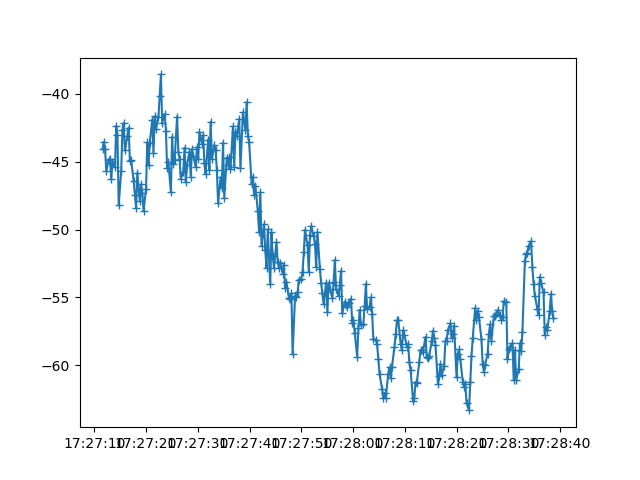

In [162]:
plt.figure()
plt.plot(T,W,marker='+')
    

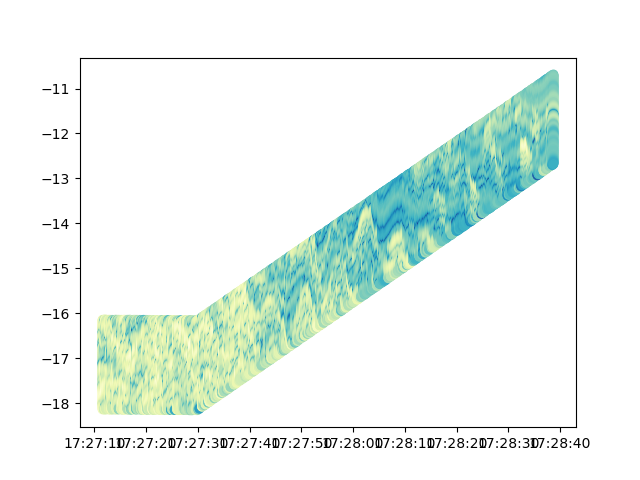

In [163]:
plt.figure()
for l0,l1,t,v in zip(L0,L1,T,V):
    plt.scatter([t]*len(v),-np.linspace(l0,l1,len(v)),c=v,vmin=-100,vmax=-30,cmap='YlGnBu_r')
    

In [105]:
wci

array([-68.471146, -52.414207], dtype=float32)

In [100]:
np.array(E0) - np.array(L0)

array([-0.00449991, -0.00450039, -0.00450039, ..., -0.00449991,
       -0.00449991, -0.00450039], shape=(7935,))

In [102]:
np.array(E1) - np.array(L1)

array([0.00449991, 0.00449944, 0.00450039, ..., 0.00450039, 0.00449991,
       0.00450039], shape=(7935,))

In [8]:
import xarray as xr
import pandas as pd

def image_to_xarray(
    image, 
    extent,
    name=None,
    xdim='x',
    ydim='y',
    **attrs
):
    xres = (extent[1]-extent[0])/(image.shape[0])
    yres = (extent[3]-extent[2])/(image.shape[1])

    x_coords = [extent[0]-xres/2 +xres*x for x in range(image.shape[0])]
    y_coords = [extent[2]-yres/2 +yres*y for y in range(image.shape[1])]
    
    if isinstance(x_coords[0],datetime.datetime):
        x_coords = pd.to_datetime(x_coords).tz_localize(None)
    
    # Convert to xarray DataArray
    da = xr.DataArray(
        image,
        name=name,
        dims=[xdim, ydim],
        coords={xdim: x_coords, ydim: list(reversed(y_coords))},
        attrs=attrs,
    )

    return da

IndexError: list index out of range

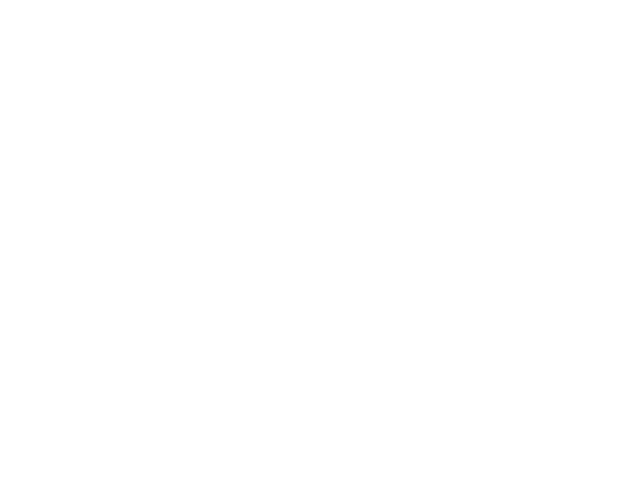

In [10]:
plt.figure()
im = image_to_xarray(
    echogramviewer.high_res_images[0],
    echogramviewer.high_res_extents[0],
    name = 'Sv (dB)',
    xdim = 'time',ydim='depth',
    #attr={
    #    'name':echogramviewer.names[0]
    #}
)

im.transpose().plot.imshow(yincrease=False,vmin=np.nanquantile(im,0.05),vmax=np.nanquantile(im,0.95), cmap='YlGnBu_r')


In [ ]:
im.to_netcdf('test.nc', format='NETCDF4')

In [ ]:
pd = im.to_pandas()
pd

In [ ]:
pd.to_csv('test.csv')